# Image Captioning with CNN, NLP, RNN and LSTM
Image captioning in deep learning refers to the process of generating textual descriptions or captions for an image automatically using deep neural networks. This task involves combining computer vision techniques to understand the visual content of an image and natural language processing (NLP) to generate a coherent and relevant textual description.

Image captioning is a popular research area in deep learning world. It combines various Neural Network types such as **Convolutional Neural Network (CNN)**, **Recurrent Neural Network (RNN)**, and RNN techniques such as **Long Short Term Memory (LSTM)** model.

## Typical steps for image captioning task
1. **Feature extraction** : Pre-trained CNNs like VGG, Resnet or Inception are used. 
2. **Sequence of words generation** : RNNs, LSTM, or Transformer-based models are used.
3. **Attention mechanism** : To enhance the captioning process, focus on different parts of the image when generating each word in the caption.
4. **Training** : The model is trained using a dataset containing pairs of images and corresponding human-generated captions.
5. **Evaluation** : Captions generated by the model are evaluated using metrics like BLEU (Bilingual Evaluation Understudy).

<div class="alert alert-success">
    <h3>Table of Content</h3>
    <ol>
        <li><a href="#Project-Goal">Project Goal</a></li>
        <li><a href="#Use-cases">Use cases</a></li>
        <li><a href="#Stakeholders">Stakeholders</a></li>
        <li><a href="#Dataset">Dataset</a></li>
        <li><a href="#Define-pre-trained-CNN-model">Define pre-trained model</a></li>
        <li><a href="#Explore-image-directory">Explore image directory</a></li>
        <li><a href="#Extract-features-from-images-in-the-directory">Extract features from images in the directory</a></li>
        <li>
            <a href="#Prepare-Text-(Caption)-data">Prepare Text (Caption) data</a>
            <ol>
                <li><a href="#Prepare-image-caption-mapping">Prepare image-caption mapping</a></li>
                <li><a href="#Examine-the-vocabulary">Examine the vocabulary</a></li>
                <li><a href="#Clean-up-the-text">Clean up the text</a></li>
                <li><a href="#Create-vocabulary">Create vocabulary</a></li>
                <li><a href="#Save-image-caption-mappings-into-a-.txt-file">Save image-caption mappings into a .txt file</a></li>
            </ol>
        </li>
        <li>
            <a href="#Model-Development">Model Development</a>
            <ol>
                <li><a href="#Load-train,-dev,-and-test-sets">Load train, dev, and test sets</a></li>
                <li><a href="#Wrap-start-and-end-tokens-around-caption-text">Wrap start and end tokens around caption text</a></li>
                <li><a href="#Load-image-features-for-train,-dev-and-test-sets">Load image features for train, dev and test sets</a></li>
                <li><a href="#Tokenize-descriptions">Tokenize descriptions</a></li>
                <li><a href="#How-the-model-is-trained?">How the model is trained?</a></li>
            </ol>
        </li>
        <li><a href="#Defining-the-Model">Defining the Model</a></li>
        <li>
            <a href="#Train-the-model">Train the model</a>
            <ol>
                <li><a href="#Prepare-train-and-dev-sets">Prepare train and dev sets</a></li>
                <li><a href="#Fit-the-model">Fit the model</a></li>                
            </ol>
        </li>
        <li>
            <a href="#Evaluate-model">Evaluate model</a>
            <ol>
                <li><a href="#Helper-functions-to-generate-caption">Helper functions to generate caption</a></li>
                <li><a href="#Prepare-test-data">Prepare test data</a></li>
                <li><a href="#Evaluate-using-BLUE-score">Evaluate using BLUE score</a></li>
            </ol>
        </li>
        <li><a href="#Generate-new-captions">Generate new captions</a></li>
    </ol>
</div>

## Project Goal
The goal of this project is to implement an image captioning application using various deep learning techniques.

## Use cases
1. Accessibility for Visually Impaired people
2. Content understanding and indexing
3. Medical imaging and diagnosis
4. Enhance user experience in social media platforms
5. Automated content creation

## Stakeholders
1. Researchers and developers
2. Technology companies and AI developers
3. Healthcare professionals
4. Social media content creators
5. and many more...

## Dataset
I'm using [Flicker 8k dataset](https://www.kaggle.com/datasets/adityajn105/flickr8k)

## Kudos 🙏
M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artifical Intellegence Research, Volume 47, pages 853-899
http://www.jair.org/papers/paper3994.html

In [3]:
#!pip install pydot

In [1]:
from os import listdir
from pickle import dump, load
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications import MobileNetV3Large
#from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import InceptionV3, VGG16, Xception
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Embedding, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model, pad_sequences, to_categorical
from tensorflow.keras.layers import Add
from tensorflow.keras.models import load_model
import string
import numpy as np
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
from collections import Counter 
import seaborn as sns

%matplotlib inline

## Define pre-trained CNN model
In  this project I will be using Keras' **IncenptionV3** model as the pre-trained model for transfer learning.

In [2]:
base_model = InceptionV3(include_top=False, weights='imagenet', pooling='max')
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [7]:
#base_model.save('models/model_InceptionV3')

- Remove the top layer which represents the classification output
- The last layer is a flatten array of 4096 parameters representing the **image features**.

## Explore image directory

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


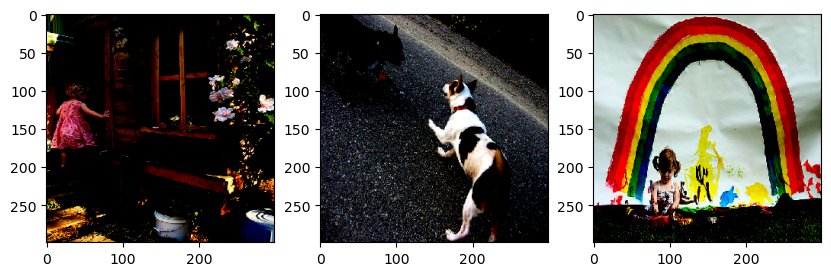

In [4]:
image_dir = 'data/Flicker8k_Dataset'
target_im_size = (299, 299)
display_count = 1
plt.figure(figsize=(10, 4))
for image in listdir(image_dir):
    img = load_img(image_dir + '/' + image, target_size=target_im_size)
    img = img_to_array(img)
    img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    plt.subplot(1, 3, display_count)
    plt.imshow(img)

    if display_count >= 3:
        break
    display_count += 1

In [5]:
print("The number of images: %d" % len(listdir(image_dir)))

The number of images: 8091


## Extract features from images in the directory
Following function will extract features from images using above InceptionV3 CNN model. Then we can save the feature set for future use.

In [6]:
def extract_features(directory):
    """
    Extract features from images in the directory provided.
    Parameter:
    - directory: Image directory name

    Return:
    - A dictionary of images. The key of each entry will be the Image ID
    """

    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=target_im_size)

        # convert image to a numpy array
        image = img_to_array(image)

        # reshape image data array suitable for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        # process the image data array for the Inception model
        image = preprocess_input(image)

        # get features
        feature = base_model.predict(image, verbose=0)

        # store features into the dictionary
        image_id = name.split('.')[0]
        features[image_id] = feature

    return features
        

Let's use above method to collect features and save it in a pickle file.

**NOTE: IF YOU ALREADY HAVE SAVED features.pkl FILE, DO NOT RUN THIS FUNCTION. IT TAKES LONG TIME TO FINISH.**

In [8]:
features = extract_features(image_dir)
print("Extracted feature sets: %d" % len(features))

# save to pickle file
feature_pkl_file = "models/features_inceptionV3.pkl"
with open(feature_pkl_file, "wb") as file:
    dump(features, file)

Extracted feature sets: 8091


Features of every image has been stores in the file now.

## Prepare Text (Caption) data
Text data contains human-generated captions (5 per each) related to every image in the dataset. Let's load them into memory.

In [10]:
def load_doc(filename):
    """
    load_doc method loads tokens from the text file
    Parameters:
        filename - String file name to read

    Return:
        File object with read tokens
    """
    with open(filename, 'r') as file:
        text = file.read()

    return text

filename = 'data/Flickr8k_text/Flickr8k.token.txt'

doc = load_doc(filename)

Previously we prepared a Python dictionary for images mapping the image ID and image name. Now we need to prepare the same structure for the caption description text as well.
Following method will perform that.

Text corpus is in following structure.
<pre>
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
</pre>

### Prepare image-caption mapping

In [11]:
def load_descriptions(doc):
    """
    This function will generate a dictionary containing caption text mapped with image ID.

    Parameters:
        doc - Text corpus document object

    Return: Dictionary containing text description mapped with image ID
    """
    mapping = dict()
    for line in doc.split('\n'):
        tokens = line.split()

        # check for empty lines
        if len(line) < 2:
            continue
        # get the image id part, and the text description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract image ID from the image_id text
        image_id = image_id.split(".")[0]
        # combine back the description text words (list elements) into a single string
        image_desc = ' '.join(image_desc)
        #initialize the mapping
        if image_id not in mapping:
            mapping[image_id] = list()
        # store image description
        mapping[image_id].append(image_desc)

    return mapping

# prepare image descriptions for read doc
description_mappings = load_descriptions(doc)

print("Number of description sets: %d" % len(description_mappings))

Number of description sets: 8092


Now we have both images and respective description text data in the same structure that we can access using image ID.

Let's plot few images and relevant description text here.

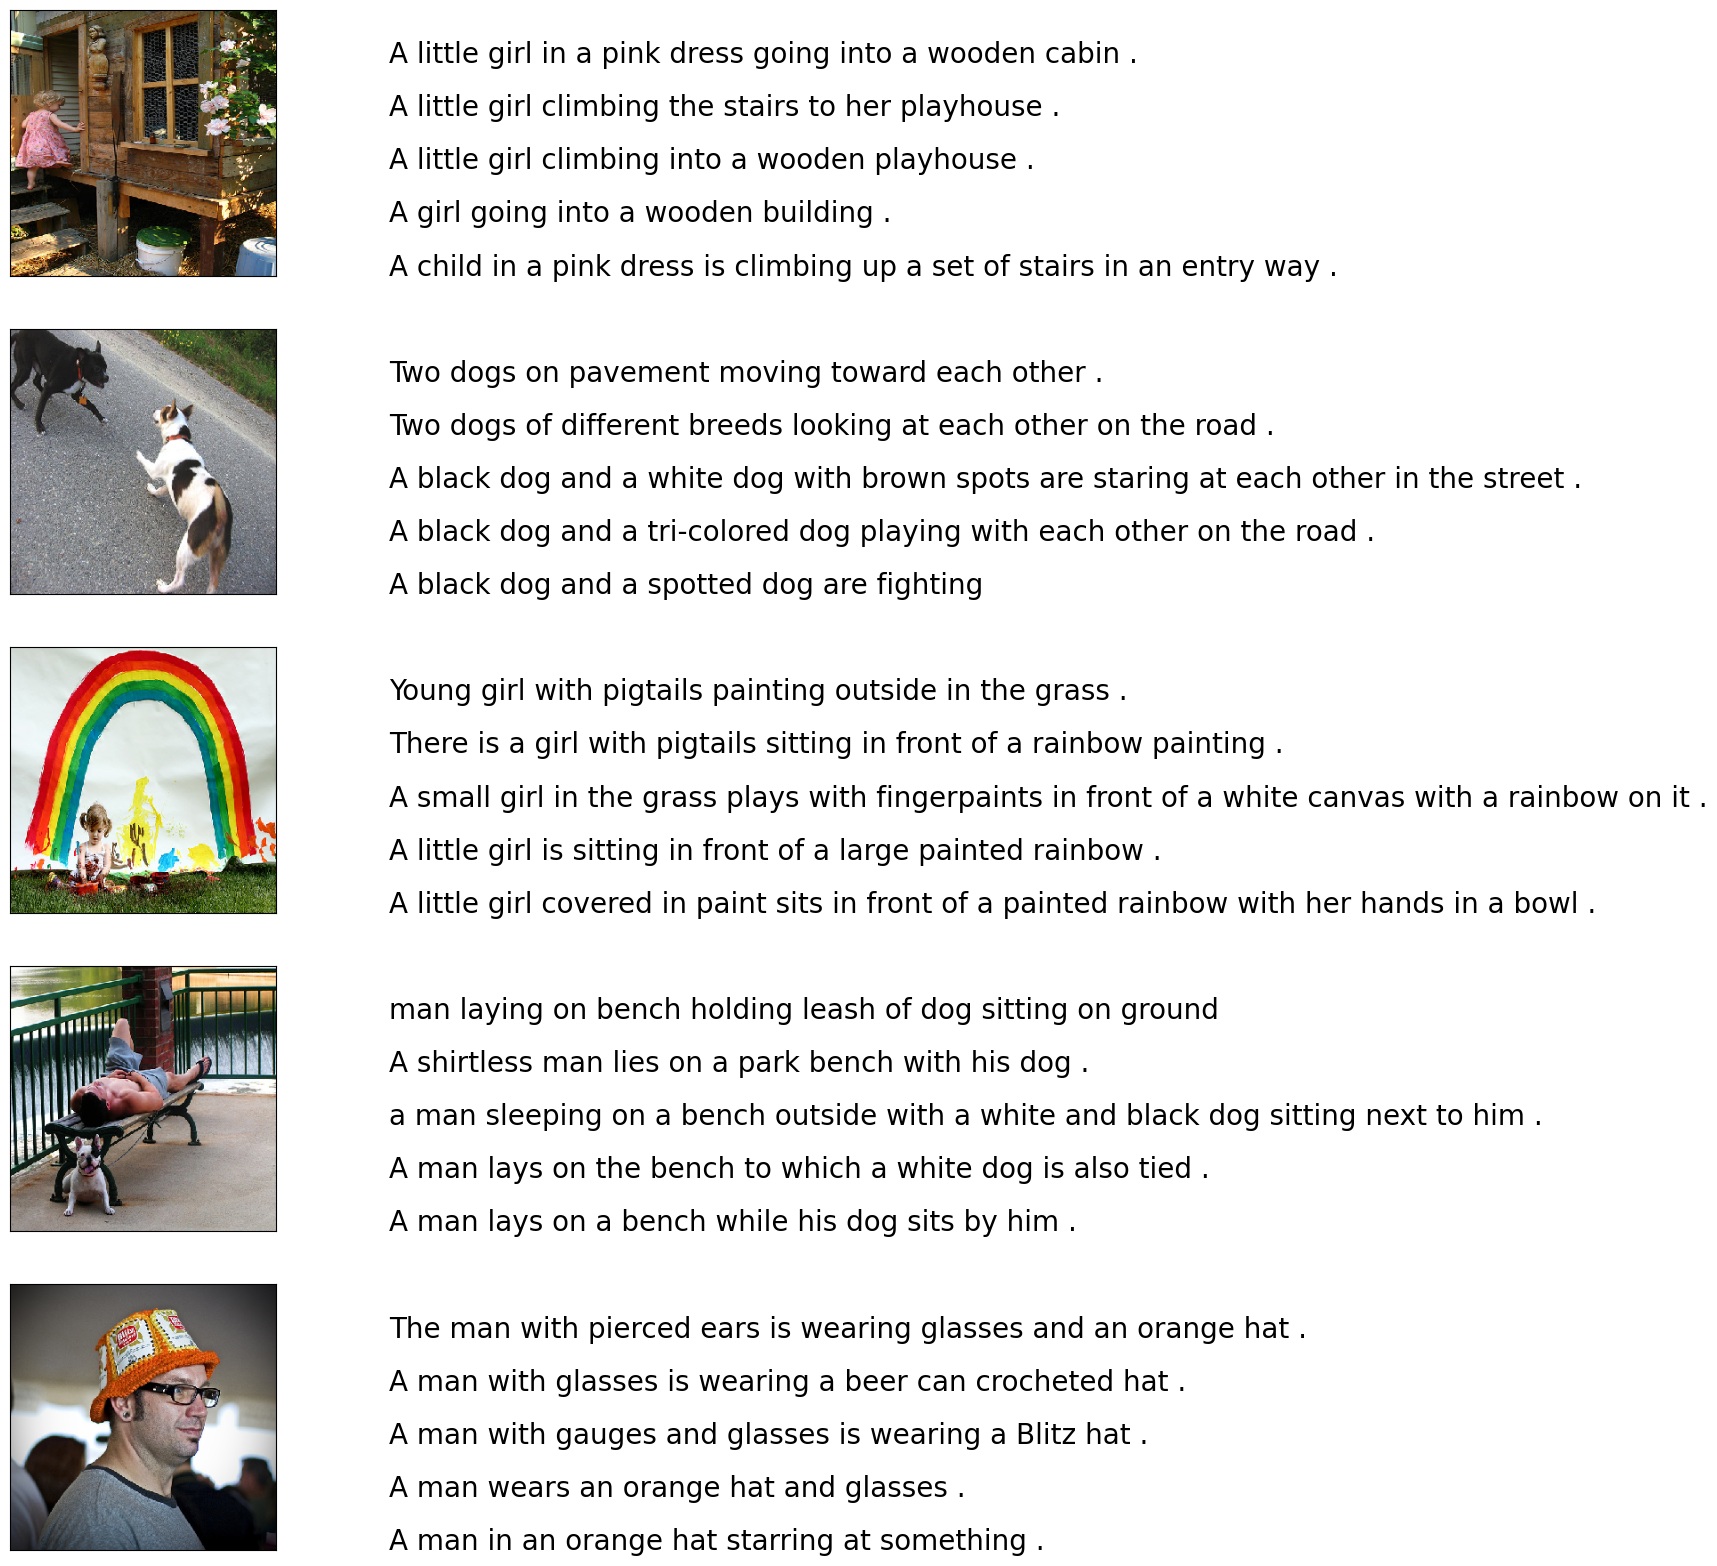

In [12]:
dir_captions = 'data/Flickr8k_text/Flickr8k.token.txt'
dir_images = 'data/Flicker8k_Dataset'
npix = 299
target_size = (npix, npix, 3)
num_of_imgs = 5

count = 1
fig = plt.figure(figsize=(10, 20))
for img in listdir(dir_images)[:num_of_imgs]:
    filename = dir_images + '/' + img
    image_id = img.split('.')[0]
    captions = description_mappings[image_id]
    image_content = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(num_of_imgs, 2, count, xticks=[], yticks=[])
    ax.imshow(image_content)
    count += 1

    ax = fig.add_subplot(num_of_imgs, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)

    count += 1

plt.show()

### Examine the vocabulary
Let's see the list of words and how many times they appear in the description.

In [13]:
def df_word(desc_dict):
    vocabulary = []
    for i in listdir(dir_images):
        for j in range(5):
            temp=desc_dict[i.split('.')[0]][j]
            vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(description_mappings)

Vocabulary Size: 9630


<IPython.core.display.Javascript object>

In [14]:
dfword

,word,count
0,a,40319
1,.,36577
2,A,22667
3,in,18962
4,the,15328
...,...,...
9625,untangles,1
9626,exception,1
9627,squeezed,1
9628,press,1


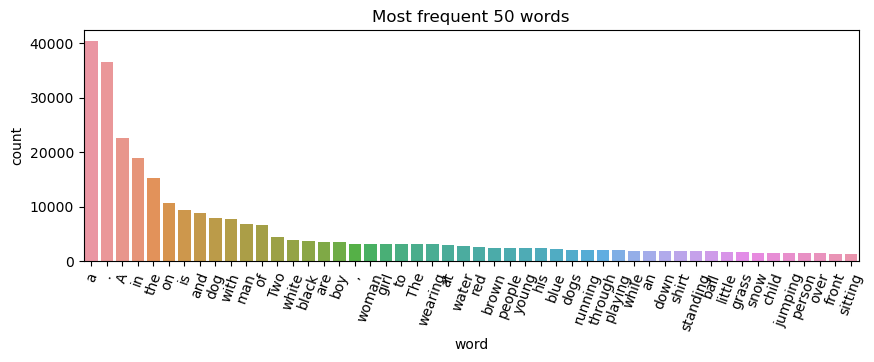

In [15]:
plt.figure(figsize=(10, 3))
plt.title('Most frequent 50 words')
sns.barplot(data=dfword.head(50), x='word', y='count')
plt.xticks(rotation=70)
plt.show()

### Clean up the text
These descriptions can contain characters which are not important for our training process. We can now remove them from the text. Following method will be responsible for performing these tasks.
1. Convert every words to lowercase
2. Remove all punctuation marks
3. Remove every single-character words such as "a"
4. Remove every word with numbers in them

In [16]:
def clean_descriptions(descriptions):
    """
    This function will clean up description text

    Parameters:
        descriptions - Description text
    """
    # prepare translation table for removing punctuation
    trans_table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lowercase
            desc = [w.lower() for w in desc]
            # remove punctuation
            desc = [w.translate(trans_table) for w in desc]
            # remove single character words
            desc = [w for w in desc if len(w) > 1]
            # remove words with numbers
            desc = [w for w in desc if w.isalpha()]
            # store as a string
            desc_list[i] = ' '.join(desc)

clean_descriptions(description_mappings)

#### After cleaning...

In [17]:
dfword_c = df_word(description_mappings)

Vocabulary Size: 8763


<IPython.core.display.Javascript object>

In [18]:
dfword_c

,word,count
0,in,18974
1,the,18418
2,on,10743
3,is,9345
4,and,8851
...,...,...
8758,leader,1
8759,poof,1
8760,goldencolored,1
8761,garments,1


### Create vocabulary
Now we have clean descriptions dictionary. Next we will create the vocabulary. We will store all words in a Python set. (No duplicates)

In [19]:
def to_vocabulary(descriptions):
    """
    This method will create the vocabulary of words
    Parameters:
        descriptions - Dictionary of description strings

    Return:
        Python Set containing words from descriptions
    """
    # build a set of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]

    return all_desc

vocabulary = to_vocabulary(description_mappings)
print("Vocabulary size: %d" % len(vocabulary))

Vocabulary size: 8763


### Save image-caption mappings into a .txt file
This step is very crucial for the performance of fitting the model. I'm running the algorithm on a CPU. So, I will simplify the vocabulary tin terms of reducing the computation cost.
My development machine has 16GB RAM. But let's go with 2 descriptions per image first and adjust it if needed.

In [20]:
def save_descriptions(descriptions, filename):
    """
    This method will write desscriptions into a .txt file.

    Parameters:
        descriptions - Python Dictionary containing description text data.
        filename - String file name with .txt extension to save text content.
    """
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list: # desc_list[:3] save 3 captions per image
            lines.append(key + ' ' + desc)

    data = '\n'.join(lines)
    with open(filename, 'w') as f:
        f.write(data)

save_descriptions(description_mappings, 'models/descriptions.txt')

## Model Development
This Flickr dataset has been divided into training, dev, and test sets. First let's load pre-defined set of image identifiers.

### Load train, dev, and test sets

In [21]:
def load_set(filename):
    """
    This function will return pre-defined image identifiers from the description text file. This function can be used to load train, dev, and test sets.
    Parameters:
        filename - Description text filename

    Return:
        Python set, containing image identifiers
    """
    doc = load_doc(filename)
    dataset = list()

    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In sequence model, the output is generated word by word. So, there should be a way to identify the start of the sentence and the end of it. Therefore, we add tokens 'startseq' at the start of the text and 'endseq' at the end of the text. Then the algorithm knows where to start and end the processing. Following function will take care of it.

### Wrap start and end tokens around caption text

In [22]:
def load_clean_descriptions(filename, dataset):
    """
    This function will return a dictionary containing descriptions with start and end tokens.
    Parameters:
        filename: String - desctiption text filename
        dataset: Python set, containing image identofiers for Train, dev, or test data set

    Return:
        Python Dictionary containing descriptions.
    """
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        token = line.split() # returns a list
        image_id, image_desc = token[0], token[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap descriptions in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)

    return descriptions

In [23]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [24]:
clean(description_mappings)

In [25]:
description_mappings['1003163366_44323f5815']

['startseq man lays on bench while his dog sits by him endseq',
 'startseq man lays on the bench to which white dog is also tied endseq',
 'startseq man sleeping on bench outside with white and black dog sitting next to him endseq',
 'startseq shirtless man lies on park bench with his dog endseq',
 'startseq man laying on bench holding leash of dog sitting on ground endseq']

In [26]:
all_captions = []
for key in description_mappings:
    for caption in description_mappings[key]:
        all_captions.append(caption)

In [27]:
len(all_captions)

40460

In [28]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Load image features for train, dev and test sets
We already have stored image feature in a pickle file. Following function will return features corresponds to train, dev, and test sets.

In [29]:
def load_photo_features(filename, dataset):
    """
    This function will open saved image features file and pick the ones for given data set. (train, dev, or test)
    Parameters:
        filename: String filename of pickle file
        dataset: Python set, containing image identofiers for Train, dev, or test dataset

    Return:
        Image features for a given dataset
    """
    # load all features
    with open(filename, 'rb') as f:
        all_features = load(f)
        # filter features
        features = {k: all_features[k] for k in dataset}
    return features

### Tokenize descriptions
Before we feed input data into the model, we need to map our words to unique integers. Keras provides the ***Tokenizer*** class that can perform this mapping from the loaded description text.

In [30]:
def to_lines(descriptions):
    """
    Convert a dictionary of descriptions to a list.
    Parameters:
        descriptions - Python dictionary of descriptions

    Return:
        A list of descriptions
    """
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]

    return all_desc

def create_tokenizer(desctiptions):
    """
    Prepare tokenizer for the descriptions text. This function will map words to unique integers using Keras Tokenizer class.

    Parameters:
        descriptions - Dictionary of descriptions.

    Return:
        Tokenized text.
    """
    lines = to_lines(desctiptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    
    return tokenizer

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [32]:
vocab_size

8766

Now we are ready to encode the text.

### How the model is trained?
1. Each description will be split into words.
2. Then model will be provided *one word* from the description and an *Image' and generate the next word.
3. Next, first two words will be provided as the inputs to the model with the image to generate the next word.

For example, the input sequence "little girl running in field" would be split into 6 input-output pairs to train the model.

<pre>
    X1,    X2 (text sequence),                          y (word)
    image  startseq,                                    little
    image  startseq, little                             girl
    image  startseq, little, girl                       running
    image  startseq, little, girl, running              in
    image  startseq, little, girl, running, in          field
    image  startseq, little, girl, running, inn field   endseq
</pre>

Later, when the model is used to generate descriptions, the generated words will be concatenated and recursively provided as input to generate a caption for an image.

In [33]:
def get_max_length(descriptions):
    """
    Helper function for calculating maximum description length.

    Parameters:
        descriptions: Dictionary of descriptions.

    Return: Integer length of the description with maximum word count.
    """
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)
    
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    """
    This function will transform the data into input-output pairs of data for training the model.

    Parameters:
        tokenizer - Tokenized descriptions text (Keras Tokenizer object)
        max_length - Integer - The length of the description with maximum words count.
        desc_list - List of descriptions for the photo
        photo - image features
        vocab_size - Integer the size of the vocabulary

    Return:
        Arrays of inputs to the model - Image features, Input words, and corresponding output words
    """
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            #encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X, y pairs
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
            
    return np.array(X1), np.array(X2), np.array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size, batch_size):
    """
    This generator fucntion is used to fit the model with data batches. CNN models need greater memory to process. This function reduces it by dividing dataset into small batches.

    Parameters:
        description: Dictionary of captions for relevant data sub set
        photos: Image features for relevant data sub set
        tokenizer: Tokenizer object
        max_length: Integer expected mximum length of caption text
        vocab_size: Integer the size of the vocabulary
        batch_size: Integer the size of a batch to be trained on

    Return:
        None
    """
    # loop for ever over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n += 1
            for desc in desc_list:
                #encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photos[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

Now we have built every function to load *train* and *development* sets and transform loaded data into input-output pairs for fitting a deep learning model

## Defining the Model
Here we use *merge-model* to define our model.
<center>
    <img src="merge_model.jpg" width=600 /><br/><small>Image credit: https://machinelearningmastery.com/</small>
</center>

We can describe the model as follows.
- **Image feature extractor**: This is a InceptionV3 model pre-trained on the ImageNet dataset. We have pre-processed images with InceptionV3 (without the output layer) and will use to extracted features predicted by this model as input.
- **Sequence processor**: This is a word embedding layer for handling the text input, followed by LSTM recurrent neural network layer.
- **Merging**: Both image features extractor and sequence processor output a fixed-length vector. These are merged together and processes by a Dense layer to make final prediction.

Functional API is used.

In [34]:
max_length = get_max_length(description_mappings)
max_length

34

In [35]:
# feature extractor model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,)) # for vgg16 4096
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(128, activation='relu')(fe1) # 256
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2) # 256
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(128)(se2) # 256
    # merger model
    merger1 = Add()([fe2, se3])
    merger2 = Dense(128, activation='relu')(merger1) # 256
    outputs = Dense(vocab_size, activation='softmax')(merger2)
    # prepare Keras Model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize the model
    print(model.summary())
    #plot_model(model, show_shapes=True)
    return model    

## Train the model
### Prepare train and dev sets

In [36]:
# load training dataset (6k)
train_filename = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(train_filename)
print("Train dataset: %d" % len(train))

# descriptions
train_descriptions = load_clean_descriptions('models/descriptions.txt', train)
print("Descriptions - train: %d" % len(train_descriptions))

# photo features
features_filename = "models/features_inceptionV3.pkl"
train_features = load_photo_features(features_filename, train)
print("Photos - train: %d" % len(train_features))

print('Vocabulary size: %d' % vocab_size)
print('Max description length - train: %d' % max_length)

# prepare sequences
#X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

Train dataset: 6000
Descriptions - train: 6000
Photos - train: 6000
Vocabulary size: 8766
Max description length - train: 34


In [37]:
# load DEV set
dev_filename = "data/Flickr8k_text/Flickr_8k.devImages.txt"
dev = load_set(dev_filename)
print('Dev dataset: %d' % len(dev))
# descriptions
dev_descriptions = load_clean_descriptions('models/descriptions.txt', dev)
print('Descriptions: dev = %d' % len(dev_descriptions))
# photo features dev
dev_features = load_photo_features(features_filename, dev)
print('Photos: dev = %d' % len(dev_features))
# prepare sequence
#X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions, dev_features, vocab_size)

Dev dataset: 1000
Descriptions: dev = 1000
Photos: dev = 1000


In [38]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, 32)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

(1754, 2048)
(1754, 34)
(1754, 8766)


### Fit the model

In [41]:
#filepath = 'model-incepv3-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

model = define_model(vocab_size, max_length)

epochs = 20
batch_size = 32

steps = len(train_descriptions) // epochs

for i in range(epochs):
    # create the data generator
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # save model
    losses = model.history.history['loss']
    print(losses)
    model_dir = 'models/model_inception-loss-{l:.3f}-itter-{itter}'.format(l=losses[0], itter=i)
    model.save(model_dir)

#model.fit([X1train, X2train], ytrain, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=([X1dev, X2dev], ydev))
#model.fit([X1train, X2train], ytrain, epochs=epochs, verbose=1, callbacks=[checkpoint], validation_data=([X1dev, X2dev], ydev))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 34)]                 0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 34, 128)              1122048   ['input_11[0][0]']            
                                                                                                  
 dropout_8 (Dropout)         (None, 2048)                 0         ['input_10[0][0]']            
                                                                                            

INFO:tensorflow:Assets written to: model_inception-loss-5.386-itter-0\assets


300/300 [==============================] - 299s 995ms/step - loss: 4.2407
[4.240654468536377]
INFO:tensorflow:Assets written to: model_inception-loss-4.241-itter-1\assets


INFO:tensorflow:Assets written to: model_inception-loss-4.241-itter-1\assets


300/300 [==============================] - 299s 997ms/step - loss: 3.8634
[3.8633933067321777]
INFO:tensorflow:Assets written to: model_inception-loss-3.863-itter-2\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.863-itter-2\assets


300/300 [==============================] - 334s 1s/step - loss: 3.6676
[3.6676406860351562]
INFO:tensorflow:Assets written to: model_inception-loss-3.668-itter-3\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.668-itter-3\assets


300/300 [==============================] - 309s 1s/step - loss: 3.5162
[3.5162224769592285]
INFO:tensorflow:Assets written to: model_inception-loss-3.516-itter-4\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.516-itter-4\assets


300/300 [==============================] - 286s 955ms/step - loss: 3.4157
[3.4156575202941895]
INFO:tensorflow:Assets written to: model_inception-loss-3.416-itter-5\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.416-itter-5\assets


300/300 [==============================] - 333s 1s/step - loss: 3.3082
[3.308248519897461]
INFO:tensorflow:Assets written to: model_inception-loss-3.308-itter-6\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.308-itter-6\assets


300/300 [==============================] - 342s 1s/step - loss: 3.2199
[3.2198572158813477]
INFO:tensorflow:Assets written to: model_inception-loss-3.220-itter-7\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.220-itter-7\assets


300/300 [==============================] - 345s 1s/step - loss: 3.1570
[3.157025098800659]
INFO:tensorflow:Assets written to: model_inception-loss-3.157-itter-8\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.157-itter-8\assets


300/300 [==============================] - 324s 1s/step - loss: 3.1121
[3.11208438873291]
INFO:tensorflow:Assets written to: model_inception-loss-3.112-itter-9\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.112-itter-9\assets


300/300 [==============================] - 483s 2s/step - loss: 3.0822
[3.082214832305908]
INFO:tensorflow:Assets written to: model_inception-loss-3.082-itter-10\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.082-itter-10\assets


300/300 [==============================] - 527s 2s/step - loss: 3.0421
[3.0420727729797363]
INFO:tensorflow:Assets written to: model_inception-loss-3.042-itter-11\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.042-itter-11\assets


300/300 [==============================] - 510s 2s/step - loss: 3.0083
[3.008281946182251]
INFO:tensorflow:Assets written to: model_inception-loss-3.008-itter-12\assets


INFO:tensorflow:Assets written to: model_inception-loss-3.008-itter-12\assets


300/300 [==============================] - 475s 2s/step - loss: 2.9778
[2.97782039642334]
INFO:tensorflow:Assets written to: model_inception-loss-2.978-itter-13\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.978-itter-13\assets


300/300 [==============================] - 507s 2s/step - loss: 2.9450
[2.944998025894165]
INFO:tensorflow:Assets written to: model_inception-loss-2.945-itter-14\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.945-itter-14\assets


300/300 [==============================] - 479s 2s/step - loss: 2.8999
[2.899904489517212]
INFO:tensorflow:Assets written to: model_inception-loss-2.900-itter-15\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.900-itter-15\assets


300/300 [==============================] - 489s 2s/step - loss: 2.8677
[2.8677239418029785]
INFO:tensorflow:Assets written to: model_inception-loss-2.868-itter-16\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.868-itter-16\assets


300/300 [==============================] - 421s 1s/step - loss: 2.8434
[2.8434438705444336]
INFO:tensorflow:Assets written to: model_inception-loss-2.843-itter-17\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.843-itter-17\assets


300/300 [==============================] - 420s 1s/step - loss: 2.8209
[2.820850133895874]
INFO:tensorflow:Assets written to: model_inception-loss-2.821-itter-18\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.821-itter-18\assets


300/300 [==============================] - 421s 1s/step - loss: 2.8084
[2.808354616165161]
INFO:tensorflow:Assets written to: model_inception-loss-2.808-itter-19\assets


INFO:tensorflow:Assets written to: model_inception-loss-2.808-itter-19\assets


## Evaluate model
Now we can evaluate the performance of fitted model on test dataset. 
1. First we generate descriptions for a photo in test set using trained model
2. Then compare generated txt with original text in the test photos and generate BLEU score.

Following functions will generate text descriptions for test set images.

### Helper functions to generate caption

In [39]:
def word_for_id(integer, tokenizer):
    """
    This function will map integer to a word in the tokenizer.

    Parameters:
        integer - Integer Word ID
        tokenizer - Keras tikenizer

    Return:
        Relevant word - If found in the tokenizer. None otherwise
    """
    for word, index in tokenizer.word_index.items():
        #print('tokenizer: %d %s' % (index, word))
        if index == integer:
            return word

    return None

def generate_desc(model, tokenizer, photo, max_length):
    """
    This function will generate description for a given image using trained model provided.

    Parameters:
        model - Trained model
        tokenizer - Keras tokenizer object
        photo - String Image ID
        max_length - Maximum length for the description

    Return:
        Generated description String
    """
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # print("output %d" % i)
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # print("output2 %s %d" % (word, yhat))
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    """
    This function will evaluate the performance of a given model.

    Parameters:
        model - Trained model
        descriptions - Actual descriptions set for the reference
        photos - Test set Image IDs
        tokenizer - Keras tokenizer generated
        max_length - Maximum description length

    Return:
        It returns nothing. But it prints BLEU scores
    """
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        reference = [d.split() for d in desc_list]
        actual.append(reference)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLUE-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLUE-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLUE-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLUE-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### Prepare test data

In [40]:
# load test set
filename = 'data/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('models/descriptions.txt', test)
print('Descriptions: test = %d' % len(test_descriptions))
# photo features
test_features = load_photo_features(features_filename, test)
print('Photos: test = %d' % len(test_features))

Dataset: 1000
Descriptions: test = 1000
Photos: test = 1000


### Evaluate using BLUE score

In [42]:
# load trained model file
model_file = 'models/model_inception-loss-2.808-itter-19'
model_obj = load_model(model_file)

evaluate_model(model_obj, test_descriptions, test_features, tokenizer, max_length)

BLUE-1: 0.518743
BLUE-2: 0.281839
BLUE-3: 0.200021
BLUE-4: 0.099382


Following BLEU results obtained by different configurations.
<div>
    <b>InceptionV3</b>
    <pre>
    BLUE-1: 0.518743
    BLUE-2: 0.281839
    BLUE-3: 0.200021
    BLUE-4: 0.099382
     </pre>
</div>
<div>
    <b>VGG16</b>
    <pre>
    BLUE-1: 0.143839
    BLUE-2: 0.066524
    BLUE-3: 0.045967
    BLUE-4: 0.014543
    </pre>
</div>
<div>
    <b>Xception</b>
    <pre>
    BLUE-1: 0.426687
    BLUE-2: 0.186792
    BLUE-3: 0.121456
    BLUE-4: 0.047316
    </pre>
</div>
<div>
    <b>MobileNet V3 - Large</b>
    <pre>
    BLUE-1: 0.523818
    BLUE-2: 0.223779
    BLUE-3: 0.137816
    BLUE-4: 0.054964
    </pre>
</div>

## Generate new captions
Now we have developed and evaluated a caption generation model. Let's try it with some real world examples.

Before everything, we can save tokenizer/vocabulary as a separate file and reuse it whenever we need. It will make the process faster. So, let's do that here.

In [43]:
#tokenizer = create_tokenizer(all_captions)
with open('models/tokenizer.pkl', 'wb') as f:
    dump(tokenizer, f)

In [44]:
from pickle import load
# load tokenizer
with open('models/tokenizer.pkl', 'rb') as f:
    tokenizer = load(f)

In [45]:
def extract_new_image_features(filename):
    # load the model
    model = base_model
    # load the photo
    image = load_img(filename, target_size=target_im_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

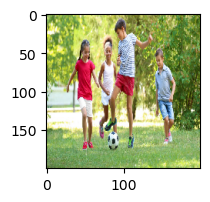

startseq two men playing soccer soccer ball endseq


In [47]:
image_filename = 'sample_images/kids.jpg'
photo = extract_new_image_features(image_filename)
# generate description
max_length = 34
plt.figure(figsize=(2, 2))
image_content = load_img(image_filename, target_size=(200, 200))
plt.imshow(image_content)
plt.show()

description = generate_desc(model_obj, tokenizer, photo, max_length)
print(description)